# 3 TESS light curve analysis
## 3.1 SAP flux

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from corner import corner

In [13]:
%run src/core.py
%run src/ctesslpf.py

<Figure size 432x288 with 0 Axes>

In [14]:
lpf = CTESSLPF('toi_263_tess_sap', 'sap', use_ldtk=False)

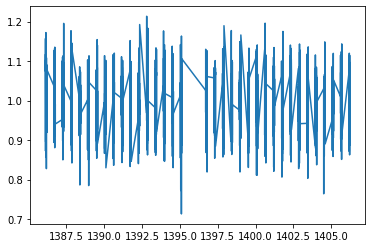

In [17]:
plot(lpf.timea, lpf.ofluxa)

In [19]:
lpf.nlc

35

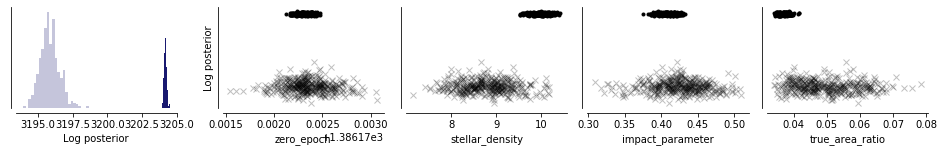

In [13]:
lpf.optimize_global(1500, 400)

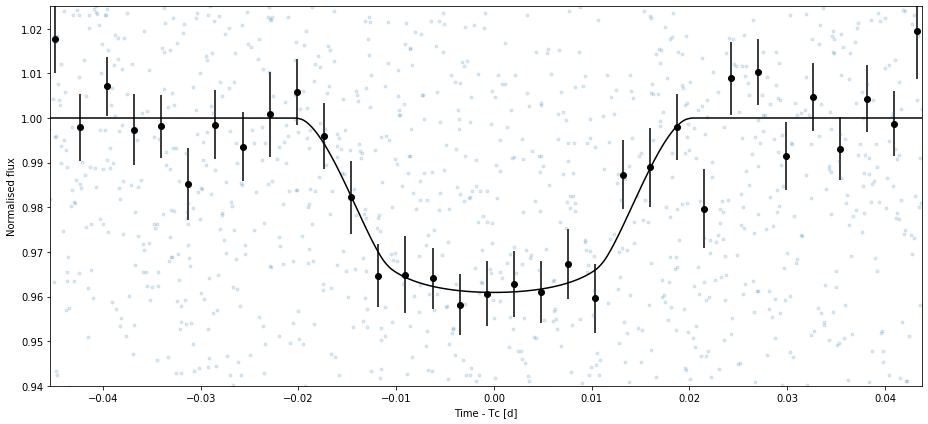

In [12]:
lpf.plot_folded_transit(ylim=(0.94,1.025), binwidth=4)

In [73]:
lpf.sample_mcmc(5000, thin=50, repeats=1)
lpf.save("results")

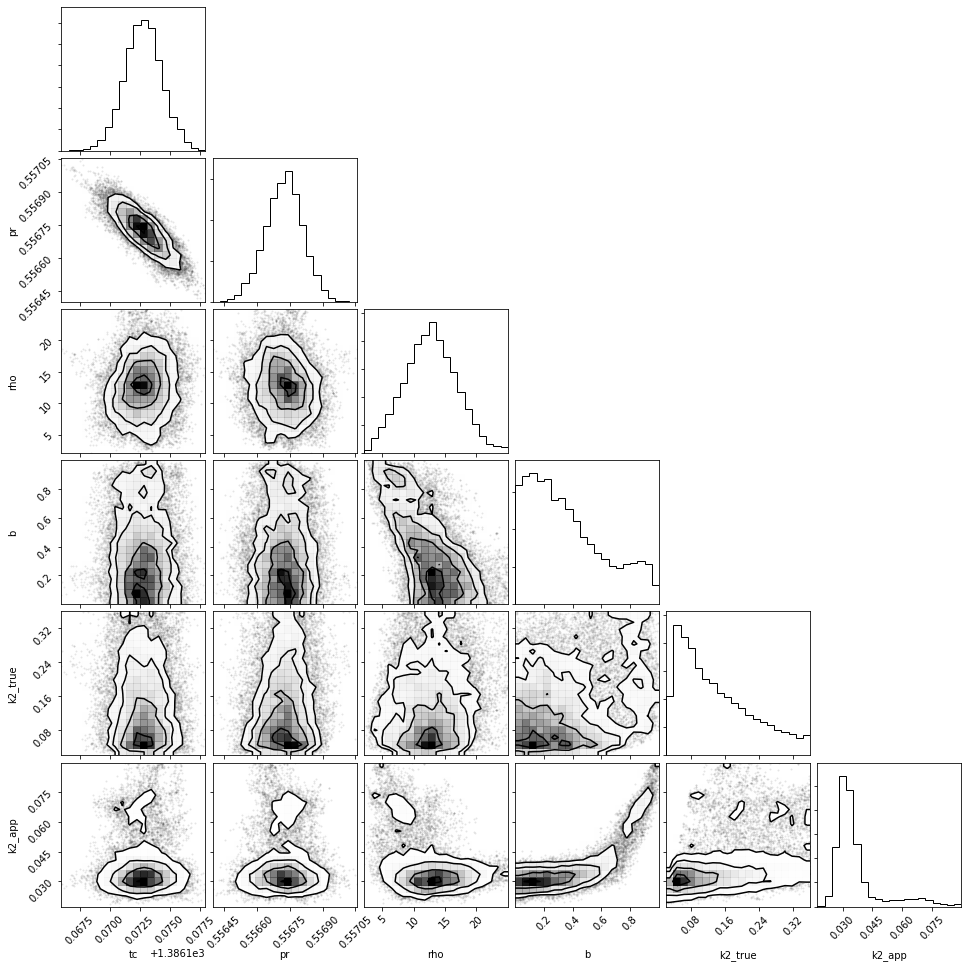

In [74]:
corner(lpf.posterior_samples().iloc[:,:]);

In [75]:
df = lpf.posterior_samples()

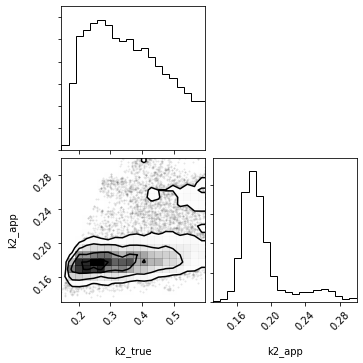

In [76]:
corner(sqrt(df.iloc[:,4:]));

In [77]:
def plot_folded_transit(self, method='de', figsize=(13, 6), ylim=(0.9975, 1.002), xlim=None, binwidth=8):
    if method == 'de':
        pv = self.de.minimum_location
        tc, p = pv[[0, 1]]
    else:
        pv = self.posterior_samples(include_ldc=True).median().values
        tc, p = pv[[0, 1]]

    phase = p * fold(self.timea, p, tc, 0.5)
    binwidth = binwidth / 24 / 60
    sids = argsort(phase)

    tm = self.transit_model(pv)
    bl = squeeze(self.baseline(pv))

    bp, bfo, beo = downsample_time(phase[sids], (self.ofluxa / bl)[sids], binwidth)

    fig, ax = subplots(figsize=figsize)
    ax.plot(phase - 0.5 * p, self.ofluxa / bl, '.', alpha=0.15)
    ax.errorbar(bp - 0.5 * p, bfo, beo, fmt='ko')
    ax.plot(phase[sids] - 0.5 * p, tm[sids], 'k')
    xlim = xlim if xlim is not None else 1.01 * (bp[isfinite(bp)][[0, -1]] - 0.5 * p)
    setp(ax, ylim=ylim, xlim=xlim, xlabel='Time - Tc [d]', ylabel='Normalised flux')
    fig.tight_layout()

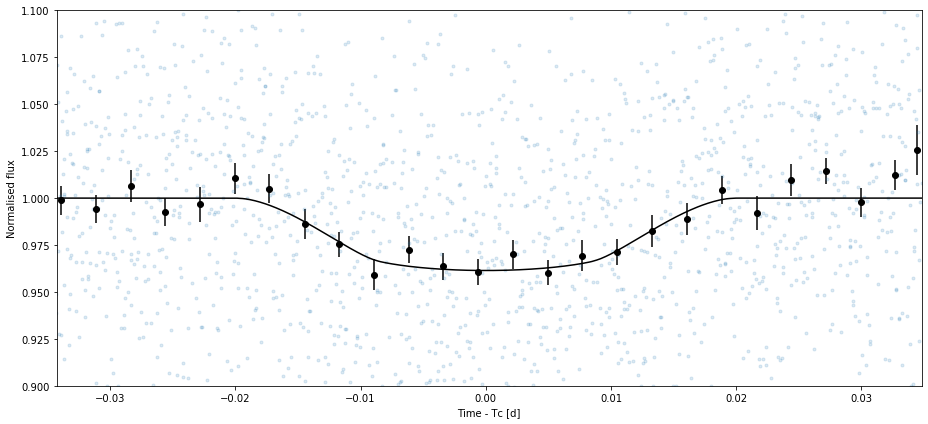

In [78]:
plot_folded_transit(lpf, 'mc', ylim=(0.9,1.1), binwidth=4)

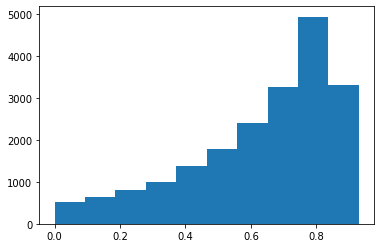

In [79]:
hist(1 - df.k2_app / df.k2_true);

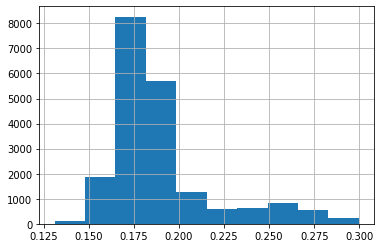

In [80]:
df = lpf.posterior_samples()
sqrt(df.k2_app).hist()

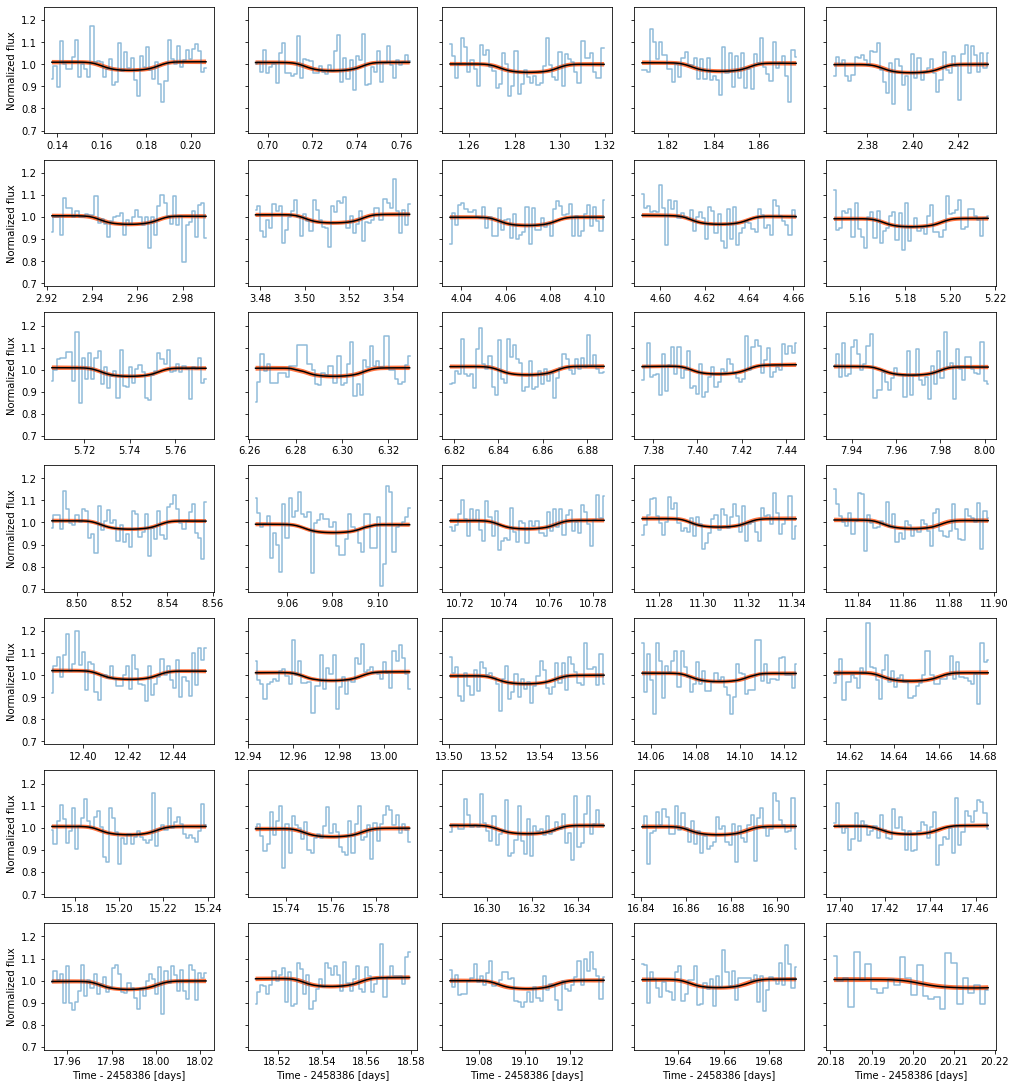

In [70]:
lpf.plot_individual_transits(ncols=5, figsize=(14,15));

In [71]:
cbl = [n for n in lpf.ps.names if 'bls' in n]
cbi = [n for n in lpf.ps.names if 'bli' in n]
cer = [n for n in lpf.ps.names if 'lne' in n]

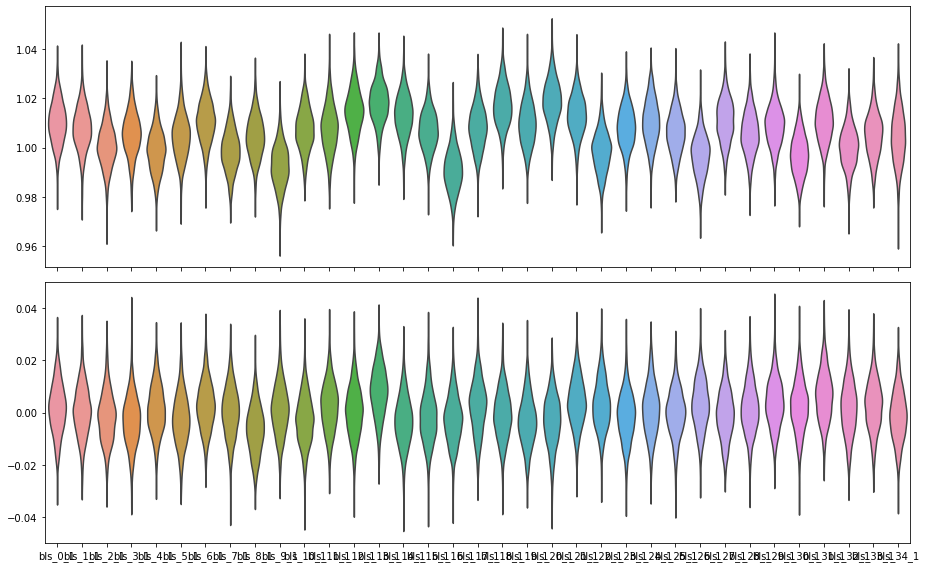

In [72]:
df = lpf.posterior_samples(include_ldc=True)
fig, axs = subplots(2, 1, figsize=(13,8), sharex=True)
sb.violinplot(data=df[cbi][::10], inner=None, ax=axs[0])
sb.violinplot(data=df[cbl][::10], inner=None, ax=axs[1])
#sb.violinplot(data=10**df[cer][::10], inner=None, ax=axs[2])
fig.tight_layout()